## Import libs, initionalize data and metric

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

Основной метрикой для подсчета качества прогноза модели будет являться кастомная метрика подсчета экономических издержек (реальные потери + упущенная выгода)

In [47]:
def custom_metric(target_col, pred_col, key=10):
    results = []
    for target, pred, key in zip(target_col, pred_col, key):
        if target >= pred:
            result = abs(target - pred) * 0.014
        else:
            result = abs(target - pred) * (key + 0.01)
        results.append(result)
    return np.mean(pd.Series(results))

In [3]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [4]:
df = pd.read_csv('ts_project_data.csv', index_col=['Date'], parse_dates=['Date']).drop(['Unnamed: 0'], axis=1) #parse_dates=['Time']
df

,Income,Outcome,Balance,Key,Inflation_diff,Key_diff,lag1,Key_lag1,lag2,Key_lag2,...,август,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,10.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2017-01-10,1.068610,1.194182,-0.125572,10.0,0.0,0.0,NaN,10.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2017-01-11,0.944429,0.936663,0.007767,10.0,0.0,0.0,NaN,10.0,NaN,10.0,...,0,0,0,0,0,0,0,0,0,0
2017-01-12,1.672202,0.875379,0.800391,10.0,0.0,0.0,NaN,10.0,NaN,10.0,...,0,0,0,0,0,0,0,0,0,0
2017-01-13,0.955924,0.975645,-0.019721,10.0,0.0,0.0,NaN,10.0,NaN,10.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,4.5,0.0,0.0,NaN,4.5,NaN,4.5,...,0,0,0,0,0,0,0,0,0,0
2021-03-28,0.000000,0.000000,0.000000,4.5,0.0,0.0,NaN,4.5,NaN,4.5,...,0,0,0,0,0,0,0,0,0,0
2021-03-29,2.356883,3.370738,-1.017679,4.5,0.0,0.0,NaN,4.5,NaN,4.5,...,0,0,0,0,0,0,0,0,0,0


## Проверка данных на стационарность

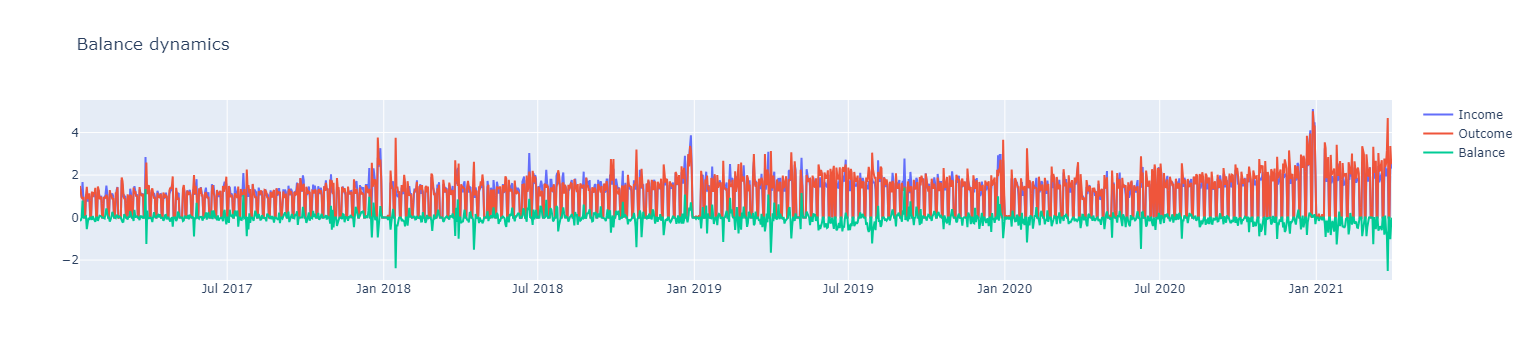

In [5]:
plotly_df(df[['Income', 'Outcome', 'Balance']], title = "Balance dynamics")

In [6]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000918


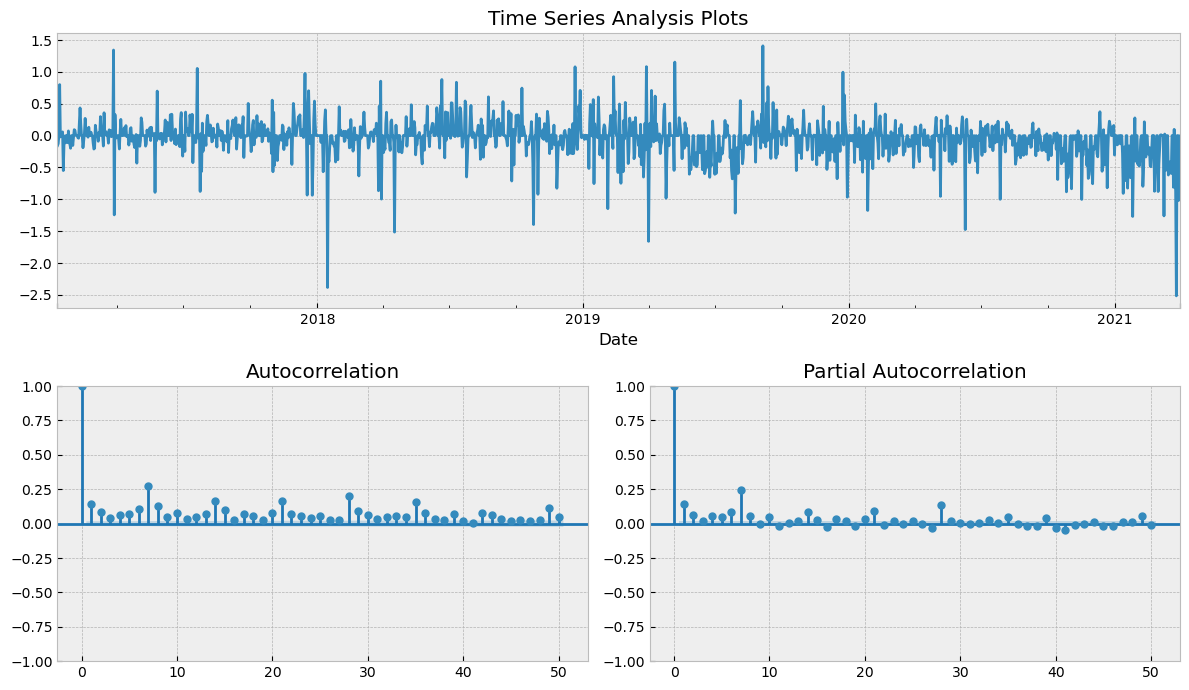

In [7]:
tsplot(df.Balance, lags=50)

Тест Дики-Фуллера отверг нулевую гипотезу о нестационарности ряда на любом разумном уровне значимости

Каждый седьмой лаг показывает высокую значимость - воспользуемся этим для инициализации подбора параметров модели

## SARIMA

In [8]:
ps = range(7, 29, 7)
d=1
qs = range(7, 29, 7)
Ps = range(0, 3)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

Формируем ООТ выборку, на которой будем проверять качество нашей модели

In [9]:
df_sarima = df[['Balance']][:-150]

### (p, q, P, Q) Selection

# Димон, тут не запускай!!!!!

In [20]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(df_sarima, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████| 48/48 [2:23:14<00:00, 179.05s/it]

        parameters         aic
23  (14, 28, 2, 0)  437.554155
22  (14, 28, 1, 0)  437.554155
21  (14, 28, 0, 0)  437.554155
11   (7, 28, 2, 0)  447.219115
10   (7, 28, 1, 0)  447.219115


### Model Summary

In [10]:
best_model = sm.tsa.statespace.SARIMAX(df_sarima.Balance, order=(14, d, 28), 
                                        seasonal_order=(2, D, 0, 24)).fit(disp=-1)
print(best_model.summary())

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                       SARIMAX Results                                       
Dep. Variable:                               Balance   No. Observations:                 1393
Model:             SARIMAX(14, 1, 28)x(2, 1, [], 24)   Log Likelihood                -188.947
Date:                               Sun, 14 Apr 2024   AIC                            467.894
Time:                                       12:22:30   BIC                            702.844
Sample:                                   01-09-2017   HQIC                           555.825
                                        - 11-01-2020                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1532      8.172     -0.141      0.888     -17.171      14.864
ar.L2      

Custom metric:  0.52582
MAE:  0.2741


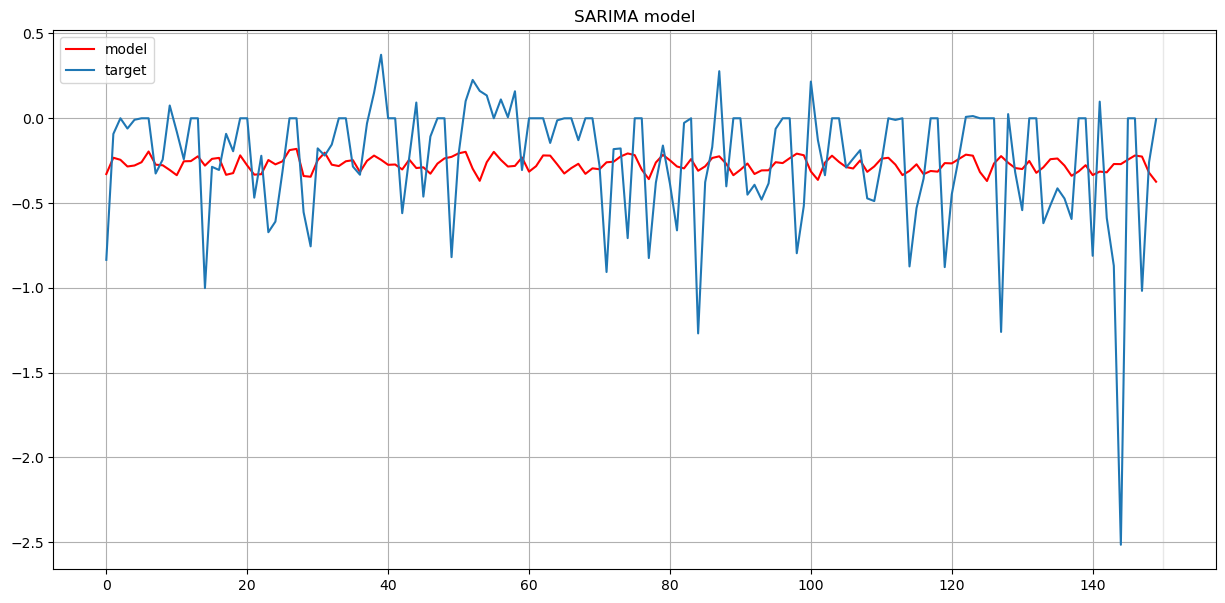

In [53]:
forecast = best_model.predict(start=0, end=len(df)-1)
preds = forecast[-150:].values
target = df.Balance.values[-150:]
print("Custom metric: ", round(custom_metric(target, preds, df['Key'][-150:]), 5))
print("MAE: ", round(mean_absolute_error(target, preds), 5))
plt.figure(figsize=(15, 7))
plt.plot(preds, color='r', label="model")
plt.title("SARIMA model")
plt.plot(target, label="target")
plt.legend()
plt.axvspan(len(target), len(preds), alpha=0.5, color='lightgrey')
plt.grid(True)

Модель достаточно плохо предсказывает движение целевой переменной, однако проходит порог по метрике MAE из условия (0.42)

## SARIMAX

Используем параметры, подсчитанные в прошлой модели, и добавляем экзогенные факторы

In [13]:
df.columns

Index(['Income', 'Outcome', 'Balance', 'Key', 'Inflation_diff', 'Key_diff',
       'lag1', 'Key_lag1', 'lag2', 'Key_lag2', 'lag3', 'Key_lag3', 'lag4',
       'Key_lag4', 'lag5', 'Key_lag5', 'lag7', 'Key_lag7', 'lag14',
       'Key_lag14', 'lag21', 'Key_lag21', 'Inflation_lag1', 'Inflation_lag2',
       'Inflation_lag3', 'Inflation_lag4', 'Inflation_lag5', 'Inflation_lag7',
       'Inflation_lag14', 'Inflation_lag21', 'Gold_lag1', 'Gold_lag2',
       'Gold_lag3', 'Gold_lag4', 'Gold_lag5', 'Gold_lag7', 'Gold_lag14',
       'Gold_lag21', 'year', 'month', 'day', 'MA7', 'MA30', 'profit_tax',
       'nds_tax', 'essb_tax', 'usd_rub_course_lag1', 'usd_rub_course_lag2',
       'usd_rub_course_lag3', 'usd_rub_course_lag4', 'usd_rub_course_lag5',
       'usd_rub_course_lag7', 'usd_rub_course_lag14', 'usd_rub_course_lag21',
       'GDP_curr_price', 'GDP_2016_price', 'GDP_2016_price_without_season',
       'GDP_2021_price', 'GDP_2021_price_without_season',
       'YoY_physical_volume_GDP', 'YoY_def

In [14]:
exog_features = ['Key', 'Inflation_diff', 'Key_diff',
       'lag1', 'Key_lag1', 'lag2', 'Key_lag2', 'lag3', 'Key_lag3', 'lag4',
       'Key_lag4', 'lag5', 'Key_lag5', 'lag7', 'Key_lag7', 'lag14',
       'Key_lag14', 'lag21', 'Key_lag21', 'Inflation_lag1', 'Inflation_lag2',
       'Inflation_lag3', 'Inflation_lag4', 'Inflation_lag5', 'Inflation_lag7',
       'Inflation_lag14', 'Inflation_lag21', 'Gold_lag1', 'Gold_lag2',
       'Gold_lag3', 'Gold_lag4', 'Gold_lag5', 'Gold_lag7', 'Gold_lag14',
       'Gold_lag21', 'year', 'month', 'day', 'MA7', 'MA30', 'profit_tax',
       'nds_tax', 'essb_tax', 'usd_rub_course_lag1', 'usd_rub_course_lag2',
       'usd_rub_course_lag3', 'usd_rub_course_lag4', 'usd_rub_course_lag5',
       'usd_rub_course_lag7', 'usd_rub_course_lag14', 'usd_rub_course_lag21',
       'GDP_curr_price',
       'YoY_physical_volume_GDP', 'YoY_deflator_GDP', 'выходной', 'праздник',
       'предпраздничный рабочий день', 'послепраздничный рабочий день',
       'последний день месяца', 'последний рабочий день месяца', 'пн', 'вт',
       'ср', 'чт', 'пт', 'сб', 'вс', 'январь', 'фебраль', 'март', 'апрель',
       'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь',
       'декабрь', '27-Дек', '28-Дек', '29-Дек', '30-Дек', '31-Дек']

In [15]:
for col in exog_features:
    df[col] = df[col].fillna(-100).astype(float)
    df[col] = np.asarray(df[col])

In [16]:
df_sarimax_train = df[:-150]

In [17]:
df_sarimax_train

,Income,Outcome,Balance,Key,Inflation_diff,Key_diff,lag1,Key_lag1,lag2,Key_lag2,...,август,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,10.00,0.0,0.0,-100.0,-100.00,-100.0,-100.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-10,1.068610,1.194182,-0.125572,10.00,0.0,0.0,-100.0,10.00,-100.0,-100.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-11,0.944429,0.936663,0.007767,10.00,0.0,0.0,-100.0,10.00,-100.0,10.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-12,1.672202,0.875379,0.800391,10.00,0.0,0.0,-100.0,10.00,-100.0,10.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-13,0.955924,0.975645,-0.019721,10.00,0.0,0.0,-100.0,10.00,-100.0,10.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28,1.790705,2.449052,-0.658957,4.25,0.0,0.0,-100.0,4.25,-100.0,4.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-29,1.830205,2.383217,-0.559080,4.25,0.0,0.0,-100.0,4.25,-100.0,4.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-30,2.146212,2.449052,-0.307402,4.25,0.0,0.0,-100.0,4.25,-100.0,4.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Номер объекта')

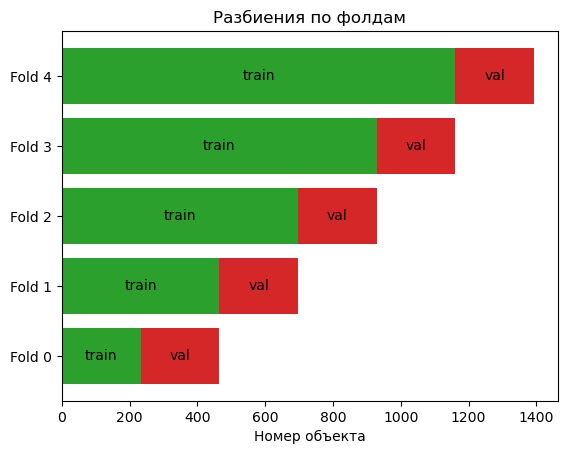

In [18]:
x_val = TimeSeriesSplit(n_splits=5)
for i, (train, val) in enumerate(x_val.split(df_sarimax_train)):
    bar = plt.barh(f'Fold {i}', train.shape[0], color='tab:green')
    plt.bar_label(bar, labels=['train'], label_type='center')

    bar = plt.barh(f'Fold {i}', val.shape[0], left=train.shape[0], color='tab:red')
    plt.bar_label(bar, labels=['val'], label_type='center')

plt.title('Разбиения по фолдам')
plt.xlabel('Номер объекта')

### Feature selection

Для начала уберем из датасета признаки, сильно скоррелированные с другими признаками, и оставим те, в которых представлено больше разнообразие значений

In [19]:
from collections import defaultdict

big_corrs = defaultdict(list)

for i in exog_features:
    for j in exog_features:
        if (abs(df_sarimax_train[[i, j]].corr().iloc[0,1]) > 0.7) & (i != j):
            big_corrs[i].append(j)

In [20]:
selected_corr_features = []

for i in big_corrs.keys():
    max_unique = 0
    best_col = None
    for col in big_corrs[i] + [i]:
        unique_count = df_sarimax_train[col].nunique()
        if unique_count > max_unique:
            max_unique = unique_count
            best_col = col
    if best_col not in selected_corr_features:
        selected_corr_features.append(best_col)

In [21]:
len(selected_corr_features)

13

In [22]:
features_after_corr = [col for col in exog_features if col in selected_corr_features or col not in big_corrs.keys()]
len(features_after_corr)

57

Отбираем признаки по permutation importance

In [51]:
def permutation_importance_sarimax(model, X, y, eval_metric, exog_features, key=10):
    baseline = eval_metric(y, model.fittedvalues, key)
    importance = {}
    for col in tqdm(exog_features):
        X_permuted = X[exog_features].copy()
        X_permuted[col] = np.random.permutation(X_permuted[col])
        permuted_model = sm.tsa.statespace.SARIMAX(X.Balance, exog=X_permuted)
        permuted_results = permuted_model.fit()
        permuted_score = eval_metric(y, permuted_results.fittedvalues, key)
        importance[col] = baseline - permuted_score
    return importance

Добавляем предсказания из Sarima для уменьшения времени отбора экзогенных параметров

In [38]:
df_sarimax_train['forecast'] = forecast

In [40]:
features_after_corr.append('forecast')

In [41]:
df_sarimax_train[features_after_corr]

,Inflation_diff,Key_diff,lag1,lag2,lag3,lag4,lag5,lag7,lag14,lag21,...,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек,forecast
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-01-10,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.155904
2017-01-11,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.125572
2017-01-12,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007767
2017-01-13,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262309
2020-10-29,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.285607
2020-10-30,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.257937


In [54]:
model = sm.tsa.statespace.SARIMAX(df_sarimax_train.Balance, exog=df_sarimax_train[features_after_corr])
results = model.fit()

importance = permutation_importance_sarimax(results, df_sarimax_train, df_sarimax_train.Balance, custom_metric, features_after_corr, key=df_sarimax_train.Key)
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  0%|          | 0/58 [00:00<?, ?it/s]C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  

Permutation Importance:
Gold_lag1: 0.006871924299918786
пн: 0.0013103593865450014
30-Дек: 0.0011260867486854176
usd_rub_course_lag1: 0.0009776362159283902
март: 0.00041730311986321045
31-Дек: 0.00033721640809736275
profit_tax: 0.0003171012105054327
Key_diff: 0.00026405759135217366
сентябрь: 0.0002539364042192238
Inflation_lag2: 0.00022371317055813744
usd_rub_course_lag7: 0.00017097362669171723
выходной: 0.00015833780704699318
usd_rub_course_lag2: 0.0001247830941202288
апрель: 0.00011324204055584985
январь: 0.00010107761150168759
август: 9.192776905175837e-05
ноябрь: 8.498789235855675e-05
ср: 8.129885314489549e-05
пт: 7.558867994506002e-05
предпраздничный рабочий день: 5.892389562034417e-05
usd_rub_course_lag14: 4.2671887833356514e-05
последний день месяца: 2.7094522841997204e-06
lag1: 0.0
lag2: 0.0
lag3: 0.0
lag4: 0.0
lag5: 0.0
lag7: 0.0
lag14: 0.0
lag21: 0.0
GDP_curr_price: 0.0
YoY_physical_volume_GDP: 0.0
YoY_deflator_GDP: 0.0
май: -2.4318319227223384e-06
чт: -1.2909489039536481e-05


In [55]:
print("Permutation Importance:")
for col, imp in sorted_importance:
    print(f"{col}: {imp}")

Permutation Importance:
Gold_lag1: 0.006871924299918786
пн: 0.0013103593865450014
30-Дек: 0.0011260867486854176
usd_rub_course_lag1: 0.0009776362159283902
март: 0.00041730311986321045
31-Дек: 0.00033721640809736275
profit_tax: 0.0003171012105054327
Key_diff: 0.00026405759135217366
сентябрь: 0.0002539364042192238
Inflation_lag2: 0.00022371317055813744
usd_rub_course_lag7: 0.00017097362669171723
выходной: 0.00015833780704699318
usd_rub_course_lag2: 0.0001247830941202288
апрель: 0.00011324204055584985
январь: 0.00010107761150168759
август: 9.192776905175837e-05
ноябрь: 8.498789235855675e-05
ср: 8.129885314489549e-05
пт: 7.558867994506002e-05
предпраздничный рабочий день: 5.892389562034417e-05
usd_rub_course_lag14: 4.2671887833356514e-05
последний день месяца: 2.7094522841997204e-06
lag1: 0.0
lag2: 0.0
lag3: 0.0
lag4: 0.0
lag5: 0.0
lag7: 0.0
lag14: 0.0
lag21: 0.0
GDP_curr_price: 0.0
YoY_physical_volume_GDP: 0.0
YoY_deflator_GDP: 0.0
май: -2.4318319227223384e-06
чт: -1.2909489039536481e-05


In [56]:
selected_features = ['Gold_lag1', 'пн', '30-Дек', 'usd_rub_course_lag1', 'март', '31-Дек', 'profit_tax', 'Key_diff', 'сентябрь', 'Inflation_lag2', 'usd_rub_course_lag7', 'выходной', 'usd_rub_course_lag2']

### Model fitting

Обучаем итоговую модель

In [61]:
sarimax = sm.tsa.statespace.SARIMAX(df_sarimax_train.Balance,
                                    order=(14, d, 28), 
                                    seasonal_order=(2, D, 0, 24),
                                    exog=df_sarimax_train[selected_features]).fit(disp=-1)
print(sarimax.summary())

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                       SARIMAX Results                                       
Dep. Variable:                               Balance   No. Observations:                 1393
Model:             SARIMAX(14, 1, 28)x(2, 1, [], 24)   Log Likelihood                -339.111
Date:                               Sun, 14 Apr 2024   AIC                            794.222
Time:                                       13:43:02   BIC                           1097.046
Sample:                                   01-09-2017   HQIC                           907.555
                                        - 11-01-2020                                         
Covariance Type:                                 opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gold_lag1            4.873e-05      0.000      0.306      0.759      -0.

Смотрим итоговые метрики новой модели

Custom metric:  0.13609
MAE:  0.53647


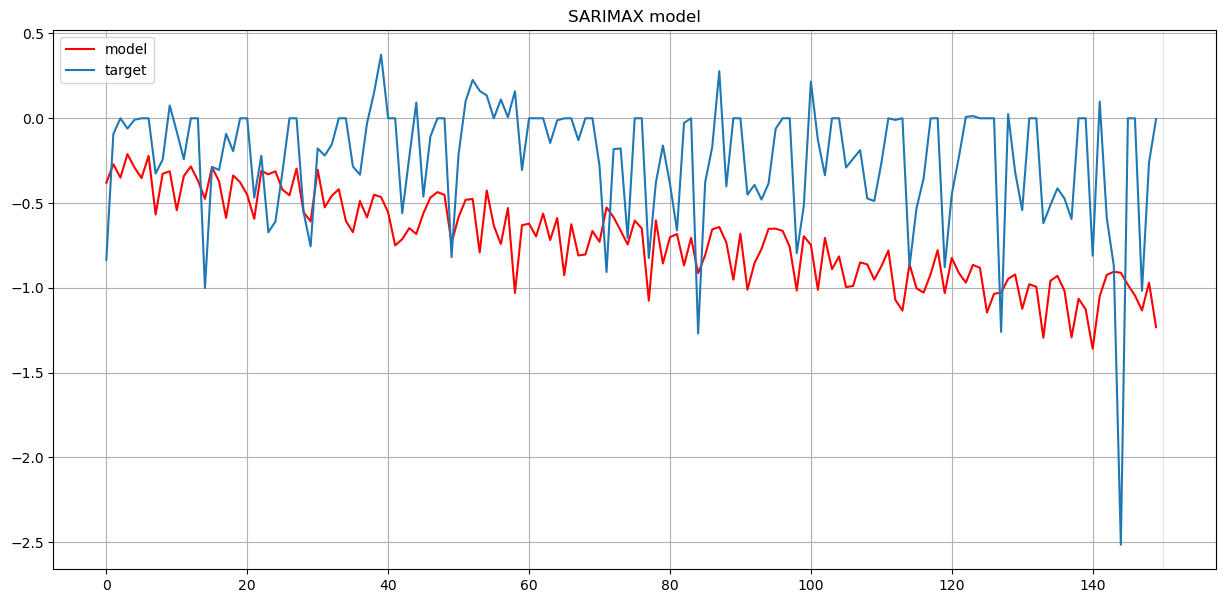

In [62]:
forecast_x = sarimax.forecast(steps=150, exog=df[selected_features][-150:])
preds = forecast_x[-150:].values
target = df.Balance.values[-150:]
print("Custom metric: ", round(custom_metric(target, preds, df['Key'][-150:]), 5))
print("MAE: ", round(mean_absolute_error(target, preds), 5))
plt.figure(figsize=(15, 7))
plt.plot(preds, color='r', label="model")
plt.title("SARIMAX model")
plt.plot(target, label="target")
plt.legend()
plt.axvspan(len(target), len(preds), alpha=0.5, color='lightgrey')
plt.grid(True)

Тут прдсказание на 150 периодов вперед, поэтому общая динамика прогноза не состыкуется с таргетом. Однако Наша основная метрика значительно снизилась (её главное отличие от МАЕ - несимметричнолсть). С точки зрения экономитческих издержек Sarimax ведет себя лучше